# Проект: вариант 2

## Задание 1. A/B–тестирование

### 1.1 Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Решение

#### 1.4.1 Чтение и исследование данных


In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

# для считывания с Я.Диска
import requests
from urllib.parse import urlencode 

# для построение графиков
import matplotlib.pyplot as plt
import seaborn as sns

# для проверки гипотез
from scipy.stats import shapiro, norm, chi2_contingency
from tqdm import tqdm

# для работы с SQL-запросами
import pandahouse as ph

In [2]:
# Функция для получения загрузочной ссылки
def read_df_from_link(public_key, sep=';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return pd.read_csv(download_url, sep=sep)


df_groups = read_df_from_link('https://disk.yandex.ru/d/58Us0DWOzuWAjg')
df_groups_add = read_df_from_link(
    'https://disk.yandex.ru/d/3aARY-P9pfaksg', sep=',')
df_active_studs = read_df_from_link('https://disk.yandex.ru/d/prbgU-rZpiXVYg')
df_check = read_df_from_link('https://disk.yandex.ru/d/84hTmELphW2sqQ')

- посмотрим на таблицы
- типы данных
- проверка на нули
- проверка на повторы

In [3]:
df_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [6]:
if len(df_groups['id'].unique()) < len(df_groups):
    print('Есть дубликаты в графе "id"!')
else:
    print('Дубликатов нет!')

Дубликатов нет!


In [7]:
df_groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [8]:
df_groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
df_groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
if len(df_groups_add['id'].unique()) < len(df_groups_add):
    print('Есть дубликаты в графе "id"!')
else:
    print('Дубликатов нет!')

Дубликатов нет!


In [11]:
df_active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [12]:
df_active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [13]:
df_active_studs.isna().sum()

student_id    0
dtype: int64

In [14]:
if len(df_active_studs['student_id'].unique()) < len(df_active_studs):
    print('Есть дубликаты в графе "student_id"!')
else:
    print('Дубликатов нет!')

Дубликатов нет!


In [15]:
df_check.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [16]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [17]:
df_check.isna().sum()

student_id    0
rev           0
dtype: int64

In [18]:
if len(df_check['student_id'].unique()) < len(df_check):
    print('Есть дубликаты в графе "student_id"!')
else:
    print('Дубликатов нет!')

Дубликатов нет!


#### 1.4.2 Обработка данных
- Делаем одинаковые заголовки (rename)
- Сложение таблиц (concat)
- Джойним таблицы на основе df_group_all (merge)

In [19]:
df_active_studs.rename(columns={'student_id': 'id'}, inplace=True)
df_check.rename(columns={'student_id': 'id'}, inplace=True)

In [20]:
df_group_all = pd.concat([df_groups, df_groups_add], ignore_index=True, axis=0)
df_group_all.shape

(74576, 2)

In [21]:
if len(df_group_all["id"].unique()) < len(df_group_all):
    print('В столбце "id" были найдены дубликаты!')
    count_duplicates = df_group_all.duplicated(["id", "grp"]).sum()  # полные дубликаты
    if count_duplicates > 0:
        df_group_all = df_group_all.drop_duplicates(subset=["id", "grp"])
    print(
        "Количество найденных и удаленных полностью одинаковых строчек:",
        count_duplicates,
    )

    count_id_duplicates = df_group_all.duplicated(
        ["id"]
    ).sum()  # дубликаты по id т.е группы пересекаются
    if count_id_duplicates > 0:
        print("Количество пересекающихся id :", count_id_duplicates)
        print(
            "Список пересекающихся id\n",
            df_group_all[df_group_all.duplicated(["id"], keep=False)],
        )
else:
    print("Дубликатов нет!")

Дубликатов нет!


Проверка на то, что в df_group_all содержатся все студенты из df_active_studs и все студенты из df_check .

In [22]:
if pd.merge(df_group_all, df_active_studs, how="inner").id.nunique() != df_active_studs.id.nunique():
    print("Есть проблема!")
else:
    print("Все ок!")

Все ок!


In [23]:
if pd.merge(df_group_all, df_check, how='inner').id.nunique() != df_check.id.nunique():
    print('Есть проблема!')
else:
    print('Все ок!')

Все ок!


In [24]:
# Новый столбец, чтобы после джойна можно было найти активных
df_active_studs['is_active'] = 1 

In [25]:
df_group_merged = pd.merge(df_group_all, df_active_studs, how='left', on='id')
df_group_merged = pd.merge(df_group_merged, df_check, how='left', on='id')
df_group_merged.head()

,id,grp,is_active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [26]:
# Заполняем нулями Null
df_group_merged = df_group_merged.fillna(0) 

#### Проверка на аномалии
Проверим существуют ли студенты, которые оплатили курс, но не были активны в день эксперимента. 
Определим количество таких студентов, если они есть, а также почему это могло произойти. 

In [27]:
df_group_merged.query('is_active==0 & rev>0').head()

,id,grp,is_active,rev
39,3185,B,0.0,690.0
121,25973,B,0.0,690.0
125,26280,B,0.0,690.0
223,100645,B,0.0,630.0
254,102534,B,0.0,580.0


In [28]:
len(df_group_merged.query('is_active==0 & rev>0'))

149

In [29]:
len(df_group_merged.query('is_active==0 & rev>0')) / len(df_group_merged.query('rev>0'))

0.2754158964879852

In [30]:
df_group_merged.query("is_active==0 & rev>0").groupby("grp", as_index=False).agg(
    {"id": "count"}
)

,grp,id
0,A,29
1,B,120


Выводы по аномалиям:
1. В таблице действительно присутствуют студенты, которые не были активны в день эксперимента, но оплатили какой-либо курс, назовем их "неактивные покупатели"
2. Их количество (149) относительно всех покупателей достаточно значительное (27.5%), а значит нам не следует их исключать при проведении последующих экспериментов
3. Такие "неактивные покупатели" присутствуют в обоих эксперементальных группах
4. Наличие таких покупателей может быть обсусловлено несколькими причинами:
    - ошибкой при сборе данных
    - задержкой при проведении оплаты
    - подписочная форма обучения
    - студент оплатил курс, чтобы заниматься в будущем

Для выявления точной причины, требуется более детальное углубление в предметную область, узнать какие есть формы и способы оплаты, а также как собирались данные

#### Итоговая таблица перед построем метрик

In [31]:
df_group_merged.head()

,id,grp,is_active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


### 1.4.3 Выбор метрик
Выберим следующие метрики, которые полностью описывают представленные данные:
1. Средний чек активных пользоваталей = Доход / Количество покупок
2. Cредняя выручка на одного пользователя (ARPU) = Доход / (Кол-во пользователей)
3. Cредняя выручка на одного активного пользователя (ARPAU) = Доход / (Кол-во активных пользоваталей)
4. Конверсия в покупку (CR) = (Кол-во покупателей /Кол-во пользователей)*100%
5. Конверсия активных пользователей в покупку (CR_ACTIVE) = (Кол-во актив. покупателей /Кол-во актив. пользоваталей)*100%

In [32]:
df_grp_A = df_group_merged[df_group_merged.grp == 'A']
df_grp_B = df_group_merged[df_group_merged.grp == 'B']

In [33]:
df_grp_A_active = df_grp_A.query('is_active==1')
df_grp_B_active = df_grp_B.query('is_active==1')

In [34]:
avg_check_A = df_grp_A_active.query('rev>0').rev.dropna().mean()
avg_check_B = df_grp_B_active.query('rev>0').rev.dropna().mean()
ARPU_A = df_grp_A.rev.sum() / df_grp_A.id.count()
ARPU_B = df_grp_B.rev.sum() / df_grp_B.id.count()
ARPAU_A = df_grp_A_active.rev.sum() / df_grp_A_active.id.count()
ARPAU_B = df_grp_B_active.rev.sum() / df_grp_B_active.id.count()
CR_A = df_grp_A.query('rev>0').id.count() / df_grp_A.id.count() * 100
CR_B = df_grp_B.query('rev>0').id.count() / df_grp_B.id.count() * 100
CR_A_active = df_grp_A_active.query(
    'rev>0').id.count() / df_grp_A_active.id.count() * 100
CR_B_active = df_grp_B_active.query(
    'rev>0').id.count() / df_grp_B_active.id.count() * 100

In [35]:
print('Основные метрики:\n\nСредний чек актив. польз.: ')
print(f'Группа А: {round(avg_check_A,2)}\nГруппа Б: {round(avg_check_B,2)}')
print('Cредняя выручка на одного пользователя (ARPU): ')
print(f'Группа А: {round(ARPU_A,2)}\nГруппа Б: {round(ARPU_B,2)}')
print('Cредняя выручка на одного активного пользователя (ARPAU): ')
print(f'Группа А: {round(ARPAU_A,2)}\nГруппа Б: {round(ARPAU_B,2)}')
print('Конверсия в покупку (CR): ')
print(f'Группа А: {round(CR_A,2)}\nГруппа Б: {round(CR_B,2)}')
print('Конверсия активных пользователей в покупку (CR_ACTIVE): ')
print(f'Группа А: {round(CR_A_active,2)}\nГруппа Б: {round(CR_B_active,2)}')

Основные метрики:

Средний чек актив. польз.: 
Группа А: 933.59
Группа Б: 1257.88
Cредняя выручка на одного пользователя (ARPU): 
Группа А: 6.27
Группа Б: 8.04
Cредняя выручка на одного активного пользователя (ARPAU): 
Группа А: 47.35
Группа Б: 58.06
Конверсия в покупку (CR): 
Группа А: 0.73
Группа Б: 0.72
Конверсия активных пользователей в покупку (CR_ACTIVE): 
Группа А: 5.07
Группа Б: 4.62


In [36]:
print(
    f'Средний чек актив. польз-ля у гр. В больше, чем у гр. А на {round((avg_check_B-avg_check_A)*100/avg_check_A)}%')
print(
    f'ARPU у группы В больше, чем у группы А на {round((ARPU_B-ARPU_A)*100/ARPU_A)}%')
print(
    f'ARPAU у группы В больше, чем у группы А на {round((ARPAU_B-ARPAU_A)*100/ARPAU_A)}%')
print(
    f'Конверсия в покупку у обоих групп отличается на {round((CR_A-CR_B)*100/CR_A,1)}%')
print(
    f'Конверсия актив. польз/ в покупку у В меньше, чем у А на {round((CR_A_active-CR_B_active)*100/CR_A_active)}%')

Средний чек актив. польз-ля у гр. В больше, чем у гр. А на 35%
ARPU у группы В больше, чем у группы А на 28%
ARPAU у группы В больше, чем у группы А на 23%
Конверсия в покупку у обоих групп отличается на 0.5%
Конверсия актив. польз/ в покупку у В меньше, чем у А на 9%


##### Выводы из метрик
По результат построения метрик, можно увидеть что средний чек и средняя вырачку у целевой группы B значительно превышает эти показатели у группы контрольной группы А, а такой важный показатель как CR почти не отличается у всех пользователей и уменьшается у активных пользоваталей. Исходя из этого требуется:
1. Рассматривать метрики только для активных пользоваталей (avg_check,ARPAU, CR_ACTIVE)
2. Исследовать данные на нормальность и выбросы
3. Проверить различие в средних чеках в разных группах
4. Понять почему конверсия в покупку у активных пользоваталей уменьшилась в целевой функции 

### 1.4.4 Проверка гипотез

Проверим следующие эксперименты:
- нормальность данных и выбросы
- средний чек
- распределение

#### 1.4.4.1 Исследование данных

In [37]:
df_grp_B_active.query('rev>0').rev.dropna().mean()

1257.8789920382164

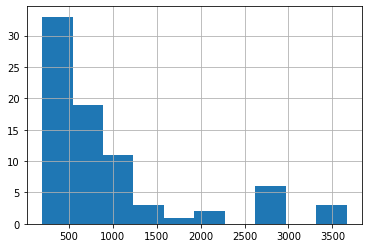

In [38]:
# Посмотрим на распределение покупок в каждой группе
df_grp_A_active.query('rev>0').rev.dropna().hist()

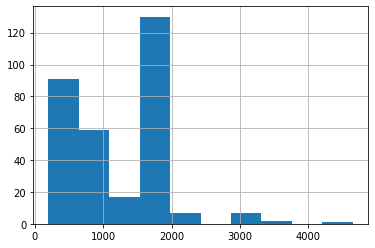

In [39]:
df_grp_B_active.query('rev>0').rev.dropna().hist()

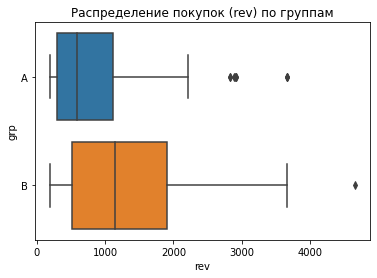

In [40]:
sns.boxplot(x="rev", y="grp", data=df_group_merged.query(
    'rev>0 & is_active==1'))
plt.title('Распределение покупок (rev) по группам')
plt.show()

In [41]:
print('Количество выбросов\nПодгруппа А -', len(df_grp_A_active.query('rev>2500')))
print('Подгруппа B -', len(df_grp_B_active.query('rev>3500')))

Количество выбросов
Подгруппа А - 9
Подгруппа B - 3


Количество выбросов незначительное,а их размер не является критическим. На основании этого можно утверждать, что выбросы не повлияют на результаты теста.

Из графиков видно, что распределения не симметричные и не нормальное, для подтверждения этих утвреждений требуется применить тест Шапиро-Уилка. Если p-уровень значимости больше 0.05, то распределение признака соотвествует нормальному (H0). Альтернативной гипотезой (H1) является то, что распределение не нормальное при p<0.05

In [42]:
shapiro(df_grp_A_active.query('rev>0').rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [43]:
shapiro(df_grp_B_active.query('rev>0').rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

p-value в обоих случаях меньше 0.05, что позволяет отклонить нулевую гипотезу и подтверждает утверждения о не нормальном распределении.

#### 1.4.4.2 Эксперимент - сравнение средних чеков (Bootstrap)

Принимая тот факт, что данные не имеют нормального распределения, используем метод Bootstrap, чтобы определить статистически значимые различия средних чеках в двух группах. Для это сформулируем гипотезы:

- H0 - разница средних чеков равна нулю
- H1 - разница средних чеков не равна нулю


In [44]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    """Функция бутстрапа из ноутбука лекции - lecture_2.2_bootstrap""" 
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        if statistic == np.mean:
            boot_data.append(statistic(samples_1 - samples_2))
        else:
            boot_data.append(statistic(samples_1) - statistic(samples_2))
            
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

100%|██████████| 1000/1000 [00:00<00:00, 3068.94it/s]


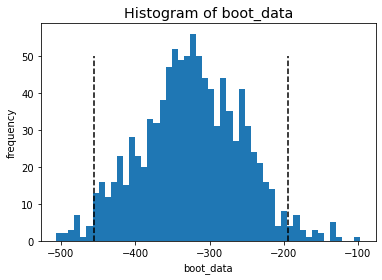

1.5900368469680545e-06

In [45]:
# По умолчанию используем метод bootstrap для средних
booted_data = get_bootstrap(df_grp_A_active.query(
    'rev>0').rev, df_grp_B_active.query('rev>0').rev)
booted_data["p_value"]

In [46]:
# Разница значений равная 0 не входит в 95% ДИ
booted_data["ci"]

,0
0.025,-455.083925
0.975,-193.855343


100%|██████████| 1000/1000 [00:00<00:00, 2145.00it/s]


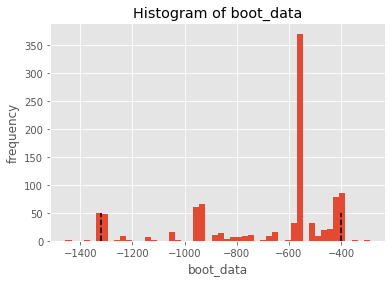

In [47]:
# Также проведем bootstrap для медиан
booted_data = get_bootstrap(df_grp_A_active.query(
    'rev>0').rev, df_grp_B_active.query('rev>0').rev, statistic=np.median, boot_it=1000)

Распределение booted_data для медиан не является нормальным, значит нам не следует рассчитывать доверительный интервал данным экспериментом.

Вывод:
На основании эксперимента Bootstrap для средних, делаем заключение, что 0 не входит в доверительный интвервал и p-value<0.05, что позволяет нам отклонить нулевую гипотезу о том что разницы средних нет. 

#### 1.4.4.3 Эксперимент - сравнение конверсий (критерий хи-квадрата)
Требуется понять  почему конверсия в покупку у активных пользоваталей уменьшилась, для этого воспользуемся критерием Хи-квадрат.
Сформулируем гипотезы:
H0: Взаимосвязи между группами и совершенными покупками НЕТ
H1: Взаимосвязь между группами и совершенными покупками ЕСТЬ

In [48]:
df_group_merged.head()

,id,grp,is_active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [49]:
# Добавим доп столбец 'is_buyer' и оставим только активных пользователей
df_group_merged['is_buyer'] = df_group_merged.rev > 0
df_group_merged_active = df_group_merged.query('is_active==1')
df_group_merged_active

,id,grp,is_active,rev,is_buyer
1,1627,A,1.0,990.0,True
10,2085,B,1.0,0.0,False
12,2215,B,1.0,0.0,False
43,3391,A,1.0,0.0,False
45,3401,B,1.0,0.0,False
...,...,...,...,...,...
74543,5760471,B,1.0,0.0,False
74545,5777081,B,1.0,0.0,False
74558,5870856,A,1.0,0.0,False
74561,5945085,B,1.0,0.0,False


In [50]:
df_for_chi2 = pd.crosstab(df_group_merged_active.grp, df_group_merged_active.is_buyer)
df_for_chi2

is_buyer,False,True
grp,,
A,1460,78
B,6489,314


In [51]:
chi2, prob, df, expected = chi2_contingency(df_for_chi2)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format(chi2, df, prob))

print(expected)

test Statistics: 0.48480826522557896
degrees of freedom: 1
p-value: 0.48625240457231045

[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


p_value > 0.05 значит оставляем нулевую гипотезу, что взаимосвязи между тестовыми группами и количеством совершенных покупок нет.

## Выводы :
1. Эксперимент Bootstrap показал, что существуют статистически значимые различия между средними чеками в контрольных группах. Причем эксперимент проводился как на средних, так и на медианах
2. Взаимосвязь между тестовыми группами и количеством совершенных покупок отсутствуют, что позволяет нам принебречь тем фактом, что CR активных пользователей в целевой группе уменьшился.
3. На основании вышесказанного, можно сделать заключение, что запускать новую механику целесообразно, это позволит увеличит средний чек, а значит и доход, однако количество совершенных покупок вероятно не изменится. 


## Задание 2. SQL

### 2.1 Очень усердные ученики

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

#### 2.1.2 Задача

Дана таблица peas.Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

##### 2.1.3 Решение

Запрос для поиска усердных студентов выполнен на основе группировки времени в массив. С помощью оператора groupArray мы собрали все дататаймы по каждому ученику, на основе размера этого массива формируется новый массив с индексами элементов в массиве. И через команду arrayMap ищем разницу во времени для текущего и i-того элемента внутри каждого массива. 

Потом сравниваем массив разниц и массив с возможными значениями этого временного переода. Например, для месяца это последовательность от 1 до 31, для часа от 1 до 59

In [52]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'
                      }

##### Тестовый запрос для проверки на имеющихся данных. 
Условие тестового запроса - вывести список студентов за все время, кто выполнил хотябы 3 горошины в месяц

In [53]:
query = '''
WITH 
    3 AS tasks_by_period,
    'day' AS check_period,
    range(0, 31) as check_period_array,    
    groupArray(timest) AS timest_array,
    arrayEnumerate(timest_array) as indexes,
    arrayMap( i -> dateDiff(check_period, timest_array[i], timest_array[i+tasks_by_period-1]), indexes) as running_diffs    
    
SELECT 
    COUNT (*) count_good_students
FROM
(
    SELECT 
        st_id
    FROM peas
        WHERE correct=1
    GROUP BY 
        st_id
    HAVING 
        hasAny(running_diffs,check_period_array)
)
'''

In [54]:
q_test = ph.read_clickhouse(query, connection=connection_default)
q_test

,count_good_students
0,1


##### Основной запрос согласно условию задачи
Условие задачи - вывести список студентов за март 2020 года, кто выполнил хотябы 20 горошин за час.

Меняем значения tasks_by_check_period - 20 и check_period - 'minute'. Также меняем массив допустимых значений - check_period_array и ограничение по дате. 

In [55]:
query = '''
WITH 
    20 AS tasks_by_period,
    'minute' AS check_period,
    range(0, 60) as check_period_array,
    
    groupArray(timest) AS timest_array,
    arrayEnumerate(timest_array) as indexes,
    arrayMap( i -> dateDiff(check_period, timest_array[i], timest_array[i+tasks_by_period-1]), indexes) as running_diffs    

SELECT 
    COUNT (*) count_good_students
FROM
(
    SELECT 
        st_id
        -- timest_array
        -- running_diffs

    FROM peas
        WHERE correct=1 AND month(timest)=3 AND year(timest)=2020
    GROUP BY 
        st_id
    HAVING 
        hasAny(running_diffs,check_period_array)
)
    '''

In [56]:
q_test = ph.read_clickhouse(query, connection=connection_default)
q_test

,count_good_students
0,0


##### Вывод:
Предоставленный датасет не позволяет в полной мере оценить правильность работы запроса, поэтому задача была упрощена и промоделирована на тестовом запросе. 

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача
Даны таблицы: peas (см. 2.1), studs и final_project_check::
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

Все данные находятся в табличном виде в Clickhouse

#### 2.2.3 Решение
Для решения пришлось выполнить несколько объединений таблиц и их группировок. Для удобства будем считать 
таблицу peas - как активных пользоваталей
таблицу final_project_check - как покупателей

1. На первом шаге был выполнен FULL JOIN заранее сгруппированных таблиц  покупателей (final_project_check) и активных пользоваталей(peas) по id  и предмету. 

2. Поскольку требуется вывести всю информацию в одном запросе и мы не можем эффективно использовать WHERE, то нам приходится сохранять отдельно все id (для джойна), id покупателей, id активных пользоваталей, id активных покупателей и т.д. 

3. Затем эта ОБЪЕДИНЕННАЯ таблица присоединяется LEFT JOIN'ом к заранее сгруппированной таблице с тестовыми группами и выводятся требуемые метрики, согласно формулам:

ARPU = Доход / (Кол-во пользователей)

ARPAU = Доход / (Кол-во активных пользоваталей)

CR = (Кол-во покупателей /Кол-во пользователей)*100% 

CR_ACTIVE = (Кол-во актив. покупателей /Кол-во актив. пользоваталей)*100%

In [57]:
query = '''
SELECT 
       A.test_grp as test_grp,
    sum(B.money)/uniqExact(B.st_id) as ARPU,
    -- ARPU = Доход / (Кол-во пользователей)
    sum(B.money)/uniqExact(B.active_id) as ARPAU,
    -- ARPAU = Доход / (Кол-во активных пользоваталей - active_id)
    (uniqExact(B.buyer_id)/uniqExact(A.st_id))*100 as CR, 
    -- CR = (Кол-во покупателей /Кол-во пользователей)*100% 
    (uniqExact(B.active_buyer_id)/uniqExact(B.active_id))*100 as CR_active,
    -- CR_ACTIVE = (Кол-во актив. покупателей /Кол-во актив. пользоваталей)*100%  
    (uniqExact(B.active_buyer_math_id)/uniqExact(B.active_math_id))*100 as CR_active_math
FROM
(
    SELECT
            st_id,
            test_grp
    FROM default.studs
    GROUP BY
        st_id,test_grp --Группируем тестовые группы, чтобы удалить повторы
) as A
LEFT JOIN -- Новая таблица, на основе ФУЛЛ ДЖОЙНА показывает активность купленных курсов и сумму покупки
(
    SELECT
        CASE
            WHEN activity.st_id !='' then activity.st_id  
            ELSE purchases.st_id
            END as st_id, -- Все id 
        CASE
            WHEN purchases.st_id  !='' then purchases.st_id   
            ELSE NULL
            END as buyer_id, -- Покупатели
        CASE
            WHEN activity.st_id  !='' then activity.st_id  
            ELSE NULL
            END as active_id, -- Активные пользователи 
        CASE
            WHEN activity.st_id  !=''AND purchases.st_id  !='' then activity.st_id  
            ELSE NULL
            END as  active_buyer_id, -- Активные покупатели
        CASE
            WHEN activity.st_id  !='' AND activity.subject = 'Math' then activity.st_id  
            ELSE NULL
            END as  active_math_id, --активные пользователи по математике
        CASE
            WHEN activity.st_id  !=''AND purchases.st_id  !='' AND activity.subject = 'Math' then activity.st_id  
            ELSE NULL
            END as  active_buyer_math_id, --активные покупатели по математике
        CASE
            WHEN activity.subject !='' then activity.subject  
            ELSE purchases.subject
            END as subject,
        purchases.money as money 
    FROM 
        (
        SELECT -- группируем активныех пользователей по предмету
            st_id,
            subject
        FROM default.peas
        GROUP BY
            st_id,
            subject
        )as activity
    FULL JOIN
        (
        SELECT -- группируем покупателей по предмету
            st_id,
            subject,
            sum(money) AS money
        FROM default.final_project_check
        GROUP BY
            st_id,
            subject
        )
        as purchases
    ON
        activity.st_id = purchases.st_id 
        AND
        activity.subject = purchases.subject 
) as B
ON A.st_id = B.st_id 

GROUP BY
    test_grp

    '''

In [58]:
q_test = ph.read_clickhouse(query, connection=connection_default)

In [59]:
q_test

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,new,117586.206897,117586.206897,100.0,96.551724,75.0
1,old,116724.137931,116724.137931,100.0,96.551724,75.0


##### Вывод 
Основные метрики согласно заданию были получены с помощью SQL-запроса. Высокий CR обусловлен данными, все студенты купили хотябы один из курсов, хотябы по одному предмету. CR активного пользователя отличается, поскольку в каждой из групп нашлось по 1 активному студенту, который не купил хотя бы 1 из курсов, который он выполнял, хотя покупал курсы, которые не проходил, поэтому CR'ы отличаются. 

## Задание 3. Python

### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### 3.2 Решение

In [60]:
df_python_task = df_group_merged

In [61]:
df_group_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [62]:
def read_df_groups_add(public_key, sep=';'):
    """Функция для получения загрузочной ссылки""" 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return pd.read_csv(download_url, sep=sep)


# Считываем все данные
df_groups = read_df_from_link('https://disk.yandex.ru/d/58Us0DWOzuWAjg')
df_groups_add = read_df_from_link(
    'https://disk.yandex.ru/d/3aARY-P9pfaksg', sep=',')
df_active_studs = read_df_from_link('https://disk.yandex.ru/d/prbgU-rZpiXVYg')
df_check = read_df_from_link('https://disk.yandex.ru/d/84hTmELphW2sqQ')

In [63]:
def merge_groups_add(groups_add, df_groups=df_groups, df_active_studs=df_active_studs, df_check=df_check):
    """Функция объединения таблиц"""
    df_active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    df_check.rename(columns={'student_id': 'id'}, inplace=True)
    
    groups_add.rename(columns={groups_add.columns[0]: "id", groups_add.columns[1]: "grp"})
    
    df_group_all = pd.concat([df_groups, groups_add],
                             ignore_index=True, axis=0)
    df_group_all.drop_duplicates(subset='id', inplace=True)
    df_active_studs['is_active'] = 1
    df_group_merged = pd.merge(
        df_group_all, df_active_studs, how='left', on='id')
    df_group_merged = pd.merge(df_group_merged, df_check, how='left', on='id')
    return df_group_merged.fillna(0)

In [64]:
def get_metrics_and_vizualisation(df_group_merged):
    """Функция расчета метрик и их визуализация"""
    df_grp_A = df_group_merged[df_group_merged.grp == 'A']
    df_grp_B = df_group_merged[df_group_merged.grp == 'B']
    avg_check_A = df_grp_A.query('rev>0').rev.dropna().mean()
    avg_check_B = df_grp_B.query('rev>0').rev.dropna().mean()
    ARPU_A = df_grp_A.rev.sum() / df_grp_A.id.count()
    ARPU_B = df_grp_B.rev.sum() / df_grp_B.id.count()
    CR_A = df_grp_A.query('rev>0').id.count() / df_grp_A.id.count() * 100
    CR_B = df_grp_B.query('rev>0').id.count() / df_grp_B.id.count() * 100
    print('Основные метрики:\n\nСредний чек.: ')
    print(
        f'Группа А: {round(avg_check_A,2)}\nГруппа Б: {round(avg_check_B,2)}')
    print('Cредняя выручка на одного пользователя (ARPU): ')
    print(f'Группа А: {round(ARPU_A,2)}\nГруппа Б: {round(ARPU_B,2)}')
    print('Конверсия в покупку (CR): ')
    print(f'Группа А: {round(CR_A,2)}\nГруппа Б: {round(CR_B,2)}')
    data_for_viz = pd.DataFrame(
        [['A', avg_check_A, ARPU_A, CR_A],
         ['B', avg_check_B, ARPU_B, CR_B]],
        columns=['grp', 'avg_check', 'ARPU', 'CR'])

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    sns.barplot(x='grp', y='avg_check', data=data_for_viz, ax=axes[0])
    axes[0].set(title='Средний чек')
    sns.barplot(x='grp', y='ARPU', data=data_for_viz, ax=axes[1])
    axes[1].set(title='ARPU')
    sns.barplot(x='grp', y='CR', data=data_for_viz, ax=axes[2])
    axes[2].set(title='Конверсия в покупку')
    plt.show()

Основные метрики:

Средний чек.: 
Группа А: 860.71
Группа Б: 1108.82
Cредняя выручка на одного пользователя (ARPU): 
Группа А: 6.27
Группа Б: 8.04
Конверсия в покупку (CR): 
Группа А: 0.73
Группа Б: 0.72


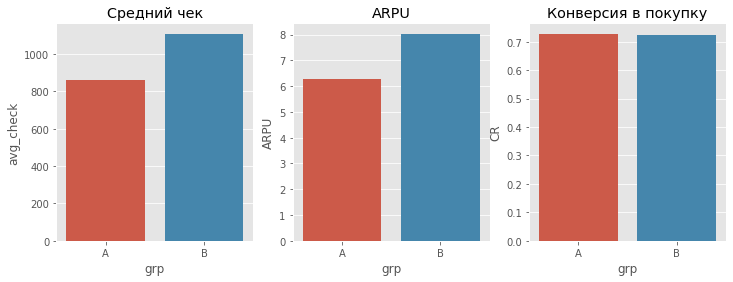

In [65]:
url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
df_groups_add_3 = read_df_groups_add(url, sep=',')
df_group_merged_3 = merge_groups_add(df_groups_add_3)
get_metrics_and_vizualisation(df_group_merged_3)